## Comparing between gradient boosting and InfiniteBoost for classification task

Experiments are run on the [UCI Higgs dataset](https://archive.ics.uci.edu/ml/datasets/HIGGS). 1 million samples are taken for training and 500,000 samples for test.

In [1]:
DATASETS_FOLDER = '../../datasets/'
N_THREADS = 4

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from collections import OrderedDict
import numpy
import joblib

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from infiniteboost import ResearchGradientBoostingBase, InfiniteBoostingWithHoldout
from infiniteboost import BinTransformer
from infiniteboost.researchlosses import LogisticLoss

Prepare training and test data from the original data

In [3]:
import os
if not os.path.isfile(DATASETS_FOLDER + '_mini_higgs.pkl'):
    import pandas
    # 1m for train, last 500000 for test
    train_data = pandas.read_csv(DATASETS_FOLDER + 'HIGGS.csv.gz', nrows=1000000, header=None).values
    test_data  = pandas.read_csv(DATASETS_FOLDER + 'HIGGS.csv.gz', skiprows=10000000, nrows=500000, header=None).values

    joblib.dump([train_data, test_data], DATASETS_FOLDER + '_mini_higgs.pkl', protocol=2)

In [4]:
train_data, test_data = joblib.load(DATASETS_FOLDER + '_mini_higgs.pkl')
trainX = train_data[:, 1:]
trainY = train_data[:, 0]
testX = test_data[:, 1:]
testY = test_data[:, 0]

Transform all features in the datasets (which are expected to be numerical) to small integers (binarization)

In [5]:
transformer = BinTransformer().fit(trainX)
bin_trainX = transformer.transform(trainX)
bin_testX  = transformer.transform(testX)

del trainX, testX

In [6]:
bin_trainX.shape, bin_testX.shape

((1000000, 28), (500000, 28))

## Training of gradient boosting and InfiniteBoost for the same parameters

In [7]:
# set parameters of boosting for all algorithms
# parameters are chosen randomly
classification_params = dict(
    loss=LogisticLoss(),
    max_depth=7, max_features=0.7, subsample=0.7, 
    n_estimators=5000,
    random_state=42,
    n_threads=N_THREADS
)

In [8]:
higgs_clfs = OrderedDict()

Train InfiniteBoost with automatically fitted capacity on the holdout (5% of the training data are used as a holdout)

In [9]:
%%time
hinfi_clf = InfiniteBoostingWithHoldout(**classification_params)
hinfi_clf.fit(bin_trainX, trainY)
higgs_clfs['inf'] = hinfi_clf

CPU times: user 1h 23min 36s, sys: 2min 43s, total: 1h 26min 19s
Wall time: 57min 18s


Train gradient boosting for different learning rates

In [10]:
for learning_rate in [0.05, 0.1, 0.2]:
    usual_clf = ResearchGradientBoostingBase(learning_rate=learning_rate, **classification_params)
    %time usual_clf.fit(bin_trainX, trainY)
    higgs_clfs[str(learning_rate)] = usual_clf
    joblib.dump(higgs_clfs, 'models/higgs_classifiers.pkl', protocol=2)

CPU times: user 1h 19min 9s, sys: 1min 31s, total: 1h 20min 41s
Wall time: 51min 55s
CPU times: user 1h 18min 58s, sys: 37.7 s, total: 1h 19min 36s
Wall time: 51min 28s
CPU times: user 1h 21min 6s, sys: 58.2 s, total: 1h 22min 4s
Wall time: 52min 55s


## Plotting

In [11]:
def compute_qualities(X, y, clfs, step=10):
    Qualities = OrderedDict()
    for name, clf in clfs.items():
        stops = []
        quals = []
        for iteration, pred in enumerate(clf.staged_decision_function(X)):
            if (iteration + 1) % step == 0:
                stops.append(iteration)
                quals.append(roc_auc_score(y, pred))
        Qualities[name] = [stops, quals]
    return Qualities

In [12]:
Qualities = compute_qualities(bin_testX, testY, clfs=higgs_clfs)
joblib.dump(Qualities, './plots/rocauc_higgs_qualities.pkl', protocol=2)

['./plots/rocauc_higgs_qualities.pkl']

In [13]:
Qualities = joblib.load('./plots/rocauc_higgs_qualities.pkl')

Comparison of InfiniteBoost and gradient boosting with different learning rates

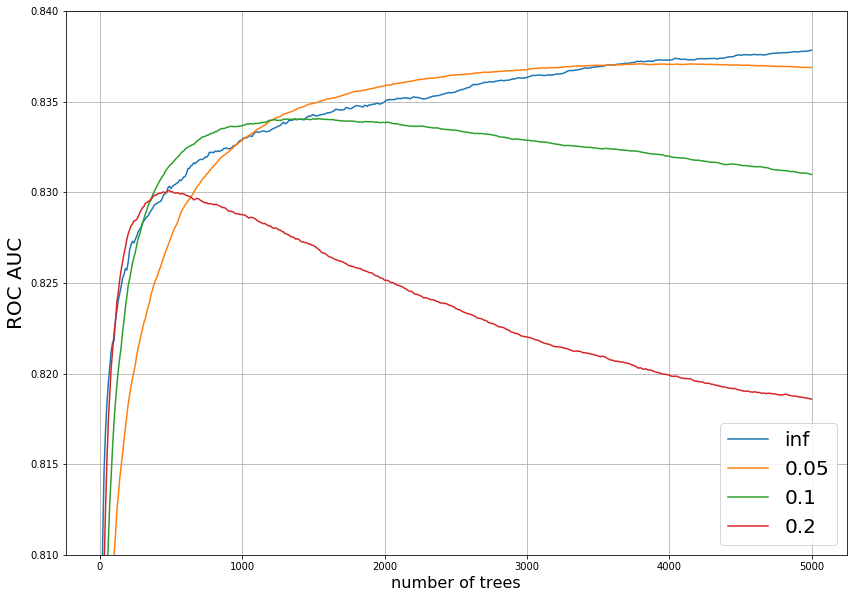

In [14]:
plt.figure(figsize=[14, 10])
for name, [stops, quals] in Qualities.items():
    plt.plot(stops, quals, label=name)

plt.xlabel('number of trees', fontsize=16)
plt.ylabel('ROC AUC', fontsize=20)
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16 
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

plt.ylim(0.81, 0.84)
plt.grid()
plt.legend(loc='lower right', fontsize=20)
plt.savefig('./plots/rocauc_higgs.pdf', bbox_inches='tight')

## Testing with other settings
(takes even more time)

Define random different settings for boosting  

In [15]:
depths = [5, 7, 9]
subsamples = [0.7, 0.5, 0.9]
colsamples = [0.9, 0.5, 0.7]

In [16]:
various_clfs = OrderedDict()
various_params = dict(
    loss=LogisticLoss(),
    n_estimators=5000,
    random_state=42,
    n_threads=N_THREADS
)

Train InfiniteBoost and gradient boosting (with learning rates 0.1 and 0.2) for chosen boosting settings

In [17]:
for depth, subsample, max_features in zip(depths, subsamples, colsamples):
    clf = InfiniteBoostingWithHoldout(max_depth=depth, subsample=subsample, max_features=max_features,
                                      **various_params)
    clf.fit(bin_trainX, trainY)
    
    various_clfs['inf', depth] = clf
    
    for learning_rate in [0.1, 0.2]:
        clf = ResearchGradientBoostingBase(learning_rate=learning_rate, 
                                           max_depth=depth, subsample=subsample, max_features=max_features,
                                           **various_params)
        clf.fit(bin_trainX, trainY)
        various_clfs[learning_rate, depth] = clf
        joblib.dump(various_clfs, './models/higgs_various_models.pkl', protocol=2)

In [18]:
various_qualities = compute_qualities(bin_testX, testY, clfs=various_clfs)
joblib.dump(various_qualities, './plots/rocauc_higgs_various_qualities.pkl', protocol=2)

['./plots/rocauc_higgs_various_qualities.pkl']

In [19]:
various_qualities = joblib.load('./plots/rocauc_higgs_various_qualities.pkl')

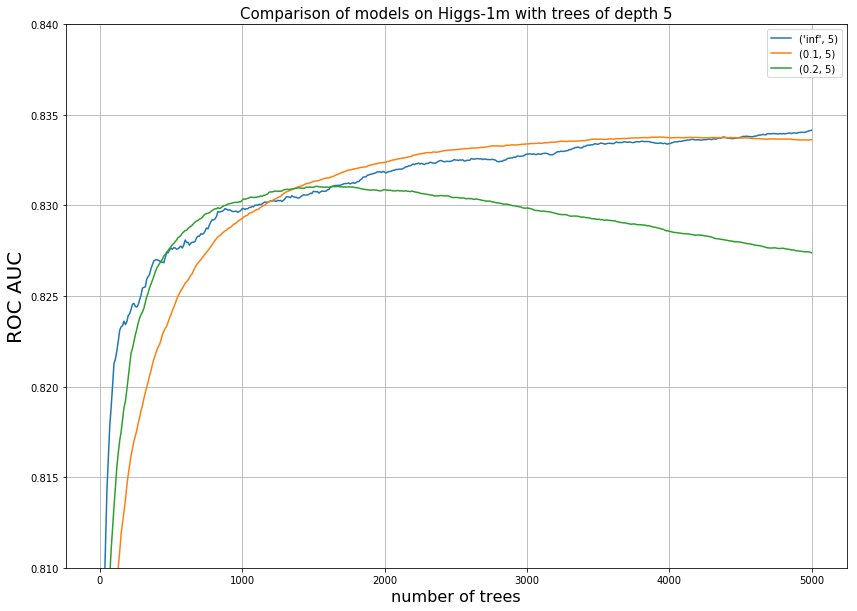

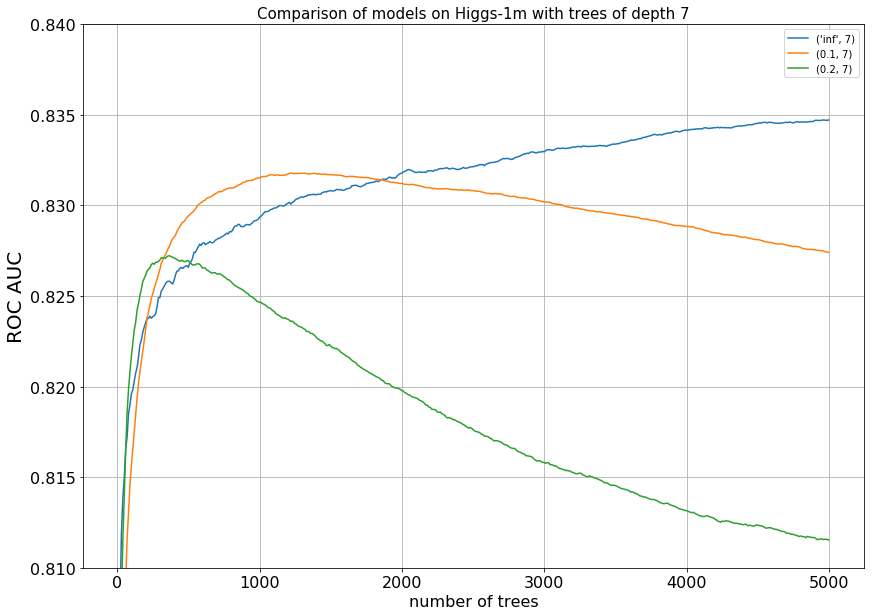

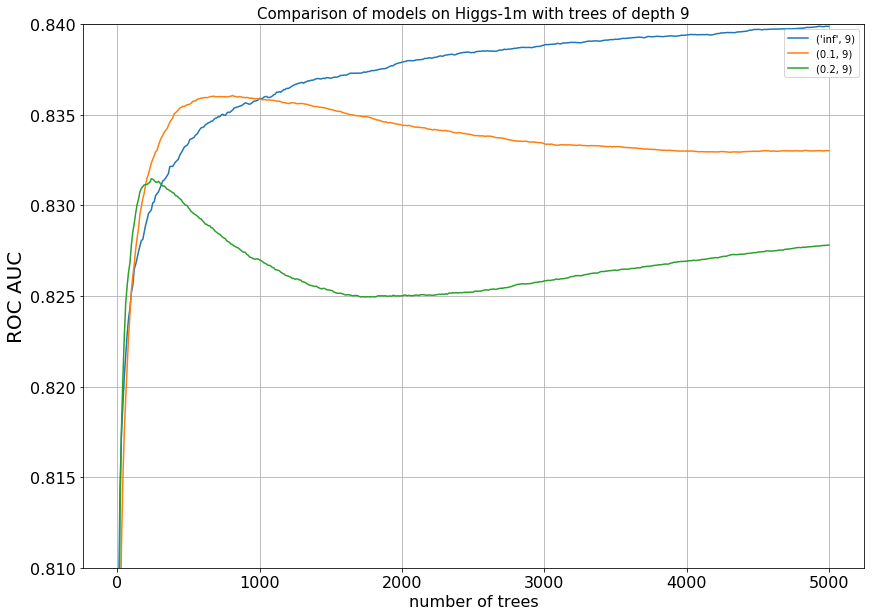

In [20]:
for plot_depth in depths:
    plt.figure(figsize=[14, 10])
    for (model, depth), (stops, quals) in various_qualities.items():
        if plot_depth == depth:
            plt.plot(stops, quals, label=(model, depth))
    plt.grid()
    plt.legend(loc='best')
    plt.ylim(0.81, 0.84)
    plt.xlabel('number of trees', fontsize=16)
    plt.ylabel('ROC AUC', fontsize=20)
    plt.rcParams['xtick.labelsize'] = 16 
    plt.rcParams['ytick.labelsize'] = 16 
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['pdf.use14corefonts'] = True
    plt.title('Comparison of models on Higgs-1m with trees of depth ' + str(plot_depth), fontsize=15)
    plt.savefig('./plots/rocauc_higgs_depth{}.pdf'.format(plot_depth), bbox_inches='tight')
    plt.show()

## Compare capacities adaptation for different depths of base trees

In [21]:
varying_depth_params = dict(
    loss=LogisticLoss(),
    max_features=0.5, 
    subsample=0.9, 
    n_estimators=2000,
    random_state=42,
    n_threads=N_THREADS
)

In [22]:
varying_depth_clfs = OrderedDict()

Train InfiniteBoost for various depths

In [23]:
for depth in [5, 7, 9, 11]:
    clf = InfiniteBoostingWithHoldout(max_depth=depth, **varying_depth_params)
    %time clf.fit(bin_trainX, trainY)
    varying_depth_clfs['inf', depth] = clf
    joblib.dump(varying_depth_clfs, './models/higgs_varying_depths.pkl')
    

CPU times: user 23min 16s, sys: 1.57 s, total: 23min 18s
Wall time: 16min 57s
CPU times: user 31min 8s, sys: 2.06 s, total: 31min 11s
Wall time: 22min 4s
CPU times: user 42min 40s, sys: 4.06 s, total: 42min 44s
Wall time: 28min 38s
CPU times: user 57min 30s, sys: 15.9 s, total: 57min 46s
Wall time: 37min 6s


In [24]:
varying_depth_clfs = joblib.load('./models/higgs_varying_depths.pkl')

Plot capacities values dependent on iterations

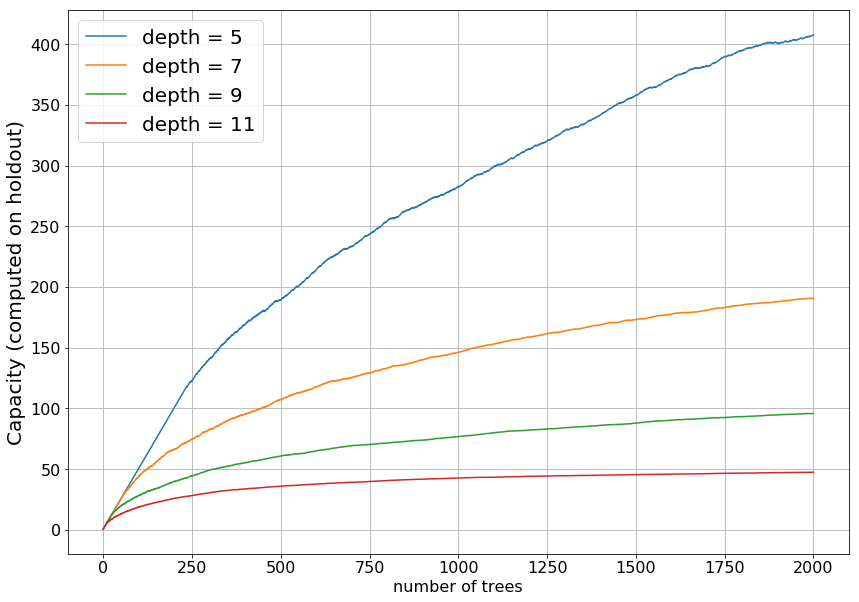

In [25]:
plt.figure(figsize=[14, 10])
for name, clf in varying_depth_clfs.items():
    plt.plot(clf.capacities, label='depth = ' + str(name[1]))
    
plt.xlabel('number of trees', fontsize=16)
plt.ylabel('Capacity (computed on holdout)', fontsize=20)
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16 

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True
    
plt.grid()
plt.legend(loc='upper left', fontsize=20, )
plt.savefig('./plots/various_depths_higgs.pdf', bbox_inches='tight')